In [4]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier



In [5]:
file_path='C:/Users/Administrator/Desktop/PROJECT-DEFECT_PREDICTION_EXTENSION/DATASET/CM1.csv'
df = pd.read_csv(file_path)
df = df.rename(columns={'problems': 'defects'})
df = df.rename(columns={'bug': 'defects'})

df['defects'] = df['defects'].replace({1: True, 0: False})
df['defects'] = df['defects'].replace({'yes': 'TRUE', 'no': 'FALSE'})
if df['defects'].dtype != bool:
    df['defects'] = df['defects'].astype(bool)

df.shape

(498, 22)

## JM1 dataset contains string '?', hence droppping the rows containing '?' 

In [7]:
# # Replace '?' with NaN in the entire DataFrame
df.replace('?', pd.NA, inplace=True)

# # Drop rows containing NaN values
df = df.dropna()

df.shape

(498, 22)

In [8]:
# DATA = pd.read_csv(file_path)
# df = DATA
DATA = df
# Separate the target variable and features

X = DATA.drop(['defects'], axis=1)
y = DATA['defects']

In [9]:
scaler=StandardScaler()
x_scaled=scaler.fit_transform(X)
x_scaled

array([[-0.66832969, -0.47755629, -0.29841641, ..., -0.64689624,
        -0.62579797, -0.52787083],
       [-0.67067103, -0.52552382, -0.40785041, ..., -0.64838012,
        -0.62809994, -0.5544364 ],
       [-0.13216334, -0.04584849, -0.40785041, ..., -0.32934638,
        -0.42092278, -0.02312486],
       ...,
       [ 1.22581255,  0.67366451,  0.13931959, ...,  1.45872639,
         1.54726022,  0.77384247],
       [-0.45995063, -0.40560499, -0.40785041, ..., -0.51483111,
        -0.48998184, -0.42160852],
       [-0.03850983,  0.07407035,  0.68648959, ..., -0.15870044,
        -0.21374563,  0.10970303]])

In [15]:
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.2,random_state=42)


## Random forest without PCA

In [360]:
model=RandomForestClassifier()
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.918918918918919

## XGBoost without PCA ( whole dataset-no feature selection)

In [43]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(x_train, y_train)
y_pred = xgb_classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision=precision_score(y_test,y_pred)
print("Precision:", precision)

recall=recall_score(y_test,y_pred)
print("Recall:",recall)

y_prob=xgb_classifier.predict_proba(x_test)[:,1]
auc=roc_auc_score(y_test,y_prob)
print("AUC:",auc)

f1=f1_score(y_test,y_pred)
print("F1 score:",f1)

Accuracy: 0.86
Precision: 0.25
Recall: 0.08333333333333333
AUC: 0.8087121212121212
F1 score: 0.125


## PCA Implementation

In [59]:
pca=PCA(n_components=10)
x_pca=pca.fit_transform(X)
x_pca.shape

(498, 10)

In [61]:
pca.n_components_

10

## Why 10 components?

In [49]:
import pandas as pd
from sklearn.decomposition import PCA

# Assuming X is your dataset
pca = PCA().fit(X)
explained_variance = pca.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance = pd.DataFrame(explained_variance).cumsum()
print(cumulative_variance)


           0
0   0.999962
1   1.000000
2   1.000000
3   1.000000
4   1.000000
5   1.000000
6   1.000000
7   1.000000
8   1.000000
9   1.000000
10  1.000000
11  1.000000
12  1.000000
13  1.000000
14  1.000000
15  1.000000
16  1.000000
17  1.000000
18  1.000000
19  1.000000
20  1.000000


In [41]:
# PCA with 95% variance explained
pca_95 = PCA(n_components=0.95)
X_pca_95 = pca_95.fit_transform(X)
print(f"Number of components for 95% variance: {X_pca_95.shape[1]}")

# PCA with 10 components
pca_10 = PCA(n_components=10)
X_pca_10 = pca_10.fit_transform(X)
variance_explained_10 = sum(pca_10.explained_variance_ratio_)
print(f"Variance explained by 10 components: {variance_explained_10}")


Number of components for 95% variance: 1
Variance explained by 10 components: 0.9999999982070258


In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Example model
model = RandomForestClassifier()

# Evaluate with PCA 95%
scores_95 = cross_val_score(model, X_pca_95, y, cv=5)
print(f"Cross-validation scores with 95% variance PCA: {scores_95.mean()}")

# Evaluate with PCA 10 components
scores_10 = cross_val_score(model, X_pca_10, y, cv=5)
print(f"Cross-validation scores with 10 components PCA: {scores_10.mean()}")


Cross-validation scores with 95% variance PCA: 0.8392525252525251
Cross-validation scores with 10 components PCA: 0.8835353535353535


## Features selected

In [53]:
X = df.iloc[:, :-1].values
feature_names = df.columns[:-1]

In [71]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Get the components (loadings)
loadings = pca.components_

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=feature_names)

# Display the features contributing to each principal component
# Here we display top contributing features for each principal component
top_n = 10 # Number of top features to display for each principal component
for i in range(loadings.shape[0]):
    print(f"\nTop {top_n} features for PC{i+1}:")
    print(loadings_df.iloc[:, i].abs().nlargest(top_n))


Top 10 features for PC1:
e             0.998398
t             0.055467
v             0.011033
n             0.001389
total_Op      0.000846
total_Opnd    0.000543
loc           0.000259
uniq_Opnd     0.000181
lOComment     0.000131
i             0.000129
Name: PC1, dtype: float64

Top 10 features for PC2:
v             0.983108
n             0.140896
total_Op      0.085756
total_Opnd    0.055137
i             0.035485
uniq_Opnd     0.027428
loc           0.025630
lOComment     0.013934
e             0.011149
lOBlank       0.010203
Name: PC2, dtype: float64

Top 10 features for PC3:
n             0.723487
total_Op      0.457762
d             0.266506
total_Opnd    0.265612
lOComment     0.197599
loc           0.166238
v             0.148083
uniq_Opnd     0.119904
uniq_Op       0.089854
i             0.083882
Name: PC3, dtype: float64

Top 10 features for PC4:
lOComment      0.699107
loc            0.496828
i              0.229070
total_Op       0.222190
branchCount    0.182403
lOBlank 

In [73]:
x_train_pca,x_test_pca,y_train,y_test=train_test_split(x_pca,y,test_size=0.2,random_state=42)

## Random Forest

In [106]:
# model=RandomForestClassifier()
# model.fit(x_train_pca,y_train)
# model.score(x_test_pca,y_test)

clf = RandomForestClassifier()
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, clf.predict_proba(x_test_pca)[:, 1])

print("Accuracy:", accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1 score:",f1)
print("AUC score:",auc)

Accuracy: 0.88
Precision: 0.0
Recall: 0.0
F1 score: 0.0
AUC score: 0.818655303030303


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN


In [120]:
input_shape = x_train_pca.shape[1]
input_shape

10

In [122]:
model_m = Sequential()
model_m.add(Reshape((input_shape, 1), input_shape=(input_shape,)))  # Reshape input for Conv1D
model_m.add(Conv1D(100, 3, activation='relu'))  # Example Conv1D layer
model_m.add(GlobalAveragePooling1D())  # GlobalAveragePooling1D layer
model_m.add(Dropout(0.5))
model_m.add(Dense(1, activation='tanh'))

model_m.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])

EPOCHS = 100
BATCH_SIZE = 64
history = model_m.fit(x_train_pca, y_train.astype('float64'),
                      batch_size=BATCH_SIZE, epochs=EPOCHS,
                      verbose=1)

accuracies = history.history['accuracy']
avg_accuracy = sum(accuracies) / len(accuracies)


Epoch 1/100


C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5029 - loss: 7.8111
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4381 - loss: 8.8034 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5706 - loss: 6.7428 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7476 - loss: 3.9997 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7718 - loss: 3.5531 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8345 - loss: 2.5689 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8865 - loss: 1.7970 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8662 - loss: 2.0700 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9027 - loss: 1.6089 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8734 - loss: 1.9747 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8751 - loss: 1.9827 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9016 - loss: 1.5687 
Ep

In [124]:
print(avg_accuracy)

0.8847487390041351


## Gaussian NB

In [110]:
clf=GaussianNB()
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, clf.predict_proba(x_test_pca)[:, 1])

print("Accuracy:", accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1 score:",f1)
print("AUC score:",auc)

Accuracy: 0.84
Precision: 0.25
Recall: 0.16666666666666666
F1 score: 0.2
AUC score: 0.8039772727272727


## AdaBoost Classifier

In [108]:
clf=AdaBoostClassifier(n_estimators=100)
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, clf.predict_proba(x_test_pca)[:, 1])

print("Accuracy:", accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1 score:",f1)
print("AUC score:",auc)

Accuracy: 0.89
Precision: 0.6666666666666666
Recall: 0.16666666666666666
F1 score: 0.26666666666666666
AUC score: 0.7500000000000001


## MLP Classifier

In [114]:
clf=MLPClassifier(random_state=1,max_iter=300)
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, clf.predict_proba(x_test_pca)[:, 1])

print("Accuracy:", accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1 score:",f1)
print("AUC score:",auc)

Accuracy: 0.88
Precision: 0.0
Recall: 0.0
F1 score: 0.0
AUC score: 0.5625


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNeighbour Classifier

In [116]:
clf=KNeighborsClassifier(n_neighbors=5,p=2,metric='minkowski')
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, clf.predict_proba(x_test_pca)[:, 1])

print("Accuracy:", accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1 score:",f1)
print("AUC score:",auc)

Accuracy: 0.88
Precision: 0.0
Recall: 0.0
F1 score: 0.0
AUC score: 0.625


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBoost PCA


In [48]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(x_train_pca, y_train)
y_pred = xgb_classifier.predict(x_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision=precision_score(y_test,y_pred)
print("Precision:", precision)

recall=recall_score(y_test,y_pred)
print("Recall:",recall)

y_prob=xgb_classifier.predict_proba(x_test_pca)[:,1]
auc=roc_auc_score(y_test,y_prob)
print("AUC:",auc)

f1=f1_score(y_test,y_pred)
print("F1 score:",f1)

Accuracy: 0.87
Precision: 0.3333333333333333
Recall: 0.08333333333333333
AUC: 0.7651515151515151
F1 score: 0.13333333333333333


## Accumulated table 

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
           Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Random Forest      0.85       0.00  0.000000  0.000000  0.775568
1     GaussianNB      0.84       0.25  0.166667  0.200000  0.803977
2       AdaBoost      0.85       0.20  0.083333  0.117647  0.730114
3            MLP      0.84       0.30  0.250000  0.272727  0.796402
4            KNN      0.88       0.00  0.000000  0.000000  0.625000
5            CNN      0.88       0.00  0.000000  0.000000  0.580019


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


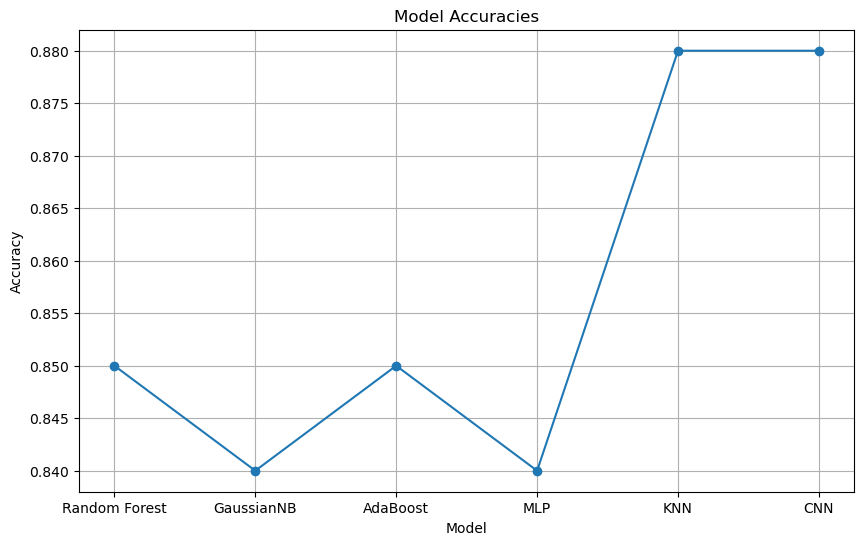

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers import Conv1D, GlobalAveragePooling1D, Dropout, Dense, Reshape
from keras.utils import to_categorical

# Assuming X_train, X_test, y_train, y_test are already defined

# Initialize the list to store results
results = []

# Random Forest model evaluation
clf = RandomForestClassifier(n_estimators=10)
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred) 
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
auc = roc_auc_score(y_test, clf.predict_proba(x_test_pca)[:, 1])

# Append the results to the list
results.append(['Random Forest', accuracy, precision, recall, f1, auc])

# Repeat similar steps for other models (GaussianNB, AdaBoost, MLP, KNN, CNN)
# GaussianNB model evaluation
gnb = GaussianNB()
gnb.fit(x_train_pca, y_train)
y_pred = gnb.predict(x_test_pca)
accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred) 
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
auc = roc_auc_score(y_test, gnb.predict_proba(x_test_pca)[:, 1]) 
results.append(['GaussianNB', accuracy, precision, recall, f1, auc])

# AdaBoost model evaluation
ada = AdaBoostClassifier()
ada.fit(x_train_pca, y_train)
y_pred = ada.predict(x_test_pca)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, ada.predict_proba(x_test_pca)[:, 1]) 
results.append(['AdaBoost', accuracy, precision, recall, f1, auc])

# MLP model evaluation
mlp = MLPClassifier(max_iter=300)
mlp.fit(x_train_pca, y_train)
y_pred = mlp.predict(x_test_pca)
accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred) 
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
auc = roc_auc_score(y_test, mlp.predict_proba(x_test_pca)[:, 1]) 
results.append(['MLP', accuracy, precision, recall, f1, auc])

# KNN model evaluation
X_train_contiguous = np.ascontiguousarray(x_train_pca)
X_test_contiguous = np.ascontiguousarray(x_test_pca)
# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
# Fit the classifier
knn.fit(X_train_contiguous, y_train)
# Make predictions
y_pred = knn.predict(X_test_contiguous)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred) 
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
y_prob = knn.predict_proba(X_test_contiguous)
auc = roc_auc_score(y_test, y_prob[:, 1])
results.append(['KNN', accuracy, precision, recall, f1, auc])

# CNN model evaluation
input_shape = x_train_pca.shape[1]
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

model = Sequential()
model.add(Reshape((input_shape, 1), input_shape=(input_shape,)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(units=128, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train_pca, y_train.astype('float64'), epochs=10, batch_size=64, verbose=0)
y_pred = (model.predict(x_test_pca) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred) 
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
y_pred_proba = model.predict(x_test_pca)
auc = roc_auc_score(y_test, y_pred_proba)
results.append(['CNN', accuracy, precision, recall, f1, auc])

# Convert the results to a DataFrame
metrics_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"])

# Print the DataFrame
print(metrics_df)

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Model"], metrics_df["Accuracy"], marker='o')
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


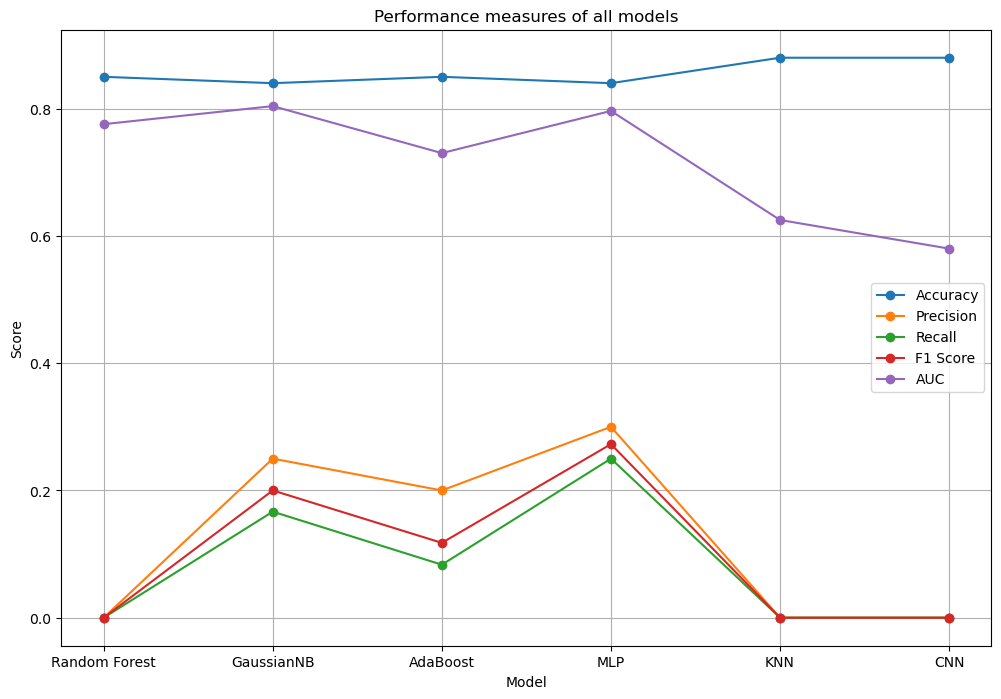

In [143]:
plt.figure(figsize=(12, 8))

for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']:
    plt.plot(metrics_df['Model'], metrics_df[metric], marker='o', label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance measures of all models')
plt.legend()
plt.grid(True)
plt.show()